
--- Running Unit Tests ---
Internet Connection: Passed
Yahoo Finance Connection: Passed
Logic Tests: Passed
All tests passed.

--- MapleTrade Prototype ---
Analyzing NVDA for past 6 months.


## <span style='color:#22bb33;font-weight:700'>Signal: BUY</span>

,Metric,Value
0,Return,7.6%
1,Sector ETF Return,-0.6%
2,Annualized Volatility,62.7%
3,1Y Target,$172.11
4,Current Price,$141.97


**Rationale:** Both outperformance and target are positive. Volatility does not prevent buy in this case.

------------------------------



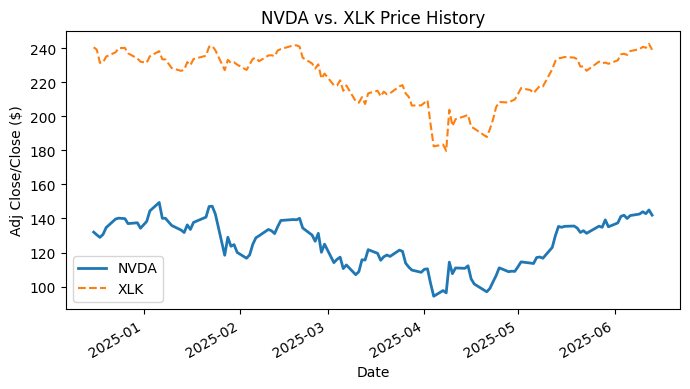

In [1]:
# MapleTrade - Prototype
# MapleTrade: Simple buy/sell/hold signal generator based on sector, volatility, target price

import yfinance as yf
import pandas as pd
import numpy as np
import socket
from datetime import datetime, timedelta
import sys
import warnings
from IPython.display import display, Markdown, HTML

# Colorama for terminal colouring; matplotlib for charting
try:
    from colorama import init, Fore, Style
    init(autoreset=True)
    COLORAMA = True
except ImportError:
    COLORAMA = False
try:
    import matplotlib.pyplot as plt
    MATPLOTLIB = True
except ImportError:
    MATPLOTLIB = False

# Suppress yfinance and future warnings for a cleaner notebook experience
warnings.filterwarnings("ignore", category=FutureWarning)

def silent_tqdm(*args, **kwargs):
    # Dummy tqdm replacement to hide progress bars in notebook
    class Dummy:
        def __enter__(self): return self
        def __exit__(self, a, b, c): return False
        def update(self, x): pass
    return Dummy()

# --- Parameters (user can change these for analysis) ---
stock_ticker = 'NVDA'   # Example: NVDA, MSFT, TSLA, DIS, CVX, BA, etc.
analysis_months = 6     # Window size (in months)
volatility_thresholds = {  # Sector-specific volatility cutoffs
    'Technology': 0.50, 'Financials': 0.38, 'Healthcare': 0.38,
    'Energy': 0.46, 'Consumer Discretionary': 0.46,
    'Industrials': 0.42, 'Utilities': 0.32,
    'Materials': 0.42, 'Real Estate': 0.38,
    'Communication Services': 0.42, 'Consumer Staples': 0.38,
    'Default': 0.42
}
show_chart = True      # Show price comparison chart
log_run = True         # Save run details to file

# Map GICS sector to sector ETF symbol
sector_etf_map = {
    'Technology': 'XLK', 'Financials': 'XLF', 'Healthcare': 'XLV',
    'Energy': 'XLE', 'Consumer Discretionary': 'XLY', 'Industrials': 'XLI',
    'Utilities': 'XLU', 'Materials': 'XLB', 'Real Estate': 'XLRE',
    'Communication Services': 'XLC', 'Consumer Staples': 'XLP',
}

def color_text(text, color):
    # Terminal text colouring for classic output
    if COLORAMA:
        return f"{color}{text}{Style.RESET_ALL}"
    else:
        return text

def check_internet():
    # Checks basic internet connectivity (Google DNS ping)
    try:
        socket.create_connection(("www.google.com", 80), 2)
        return True
    except Exception:
        return False

def check_yahoo():
    # Checks Yahoo Finance API connection by requesting AAPL info
    try:
        test = yf.Ticker('AAPL').info
        return 'regularMarketPrice' in test
    except Exception:
        return False

def get_sector_and_etf(ticker):
    # Fetch sector classification and sector ETF from Yahoo Finance for the given stock
    try:
        info = yf.Ticker(ticker).info
        sector = info.get('sector', None)
        if sector in sector_etf_map:
            etf = sector_etf_map[sector]
        else:
            etf = None
    except Exception:
        sector = None
        etf = None
    return sector, etf

def get_data(ticker, months):
    # Downloads recent price series for a given ticker
    end = datetime.today()
    start = end - timedelta(days=int(months*30.5))
    try:
        df = yf.download(ticker, start=start, end=end, progress=False)
        col_candidates = []
        # Handle both flat and MultiIndex (ticker, field) DataFrames
        if isinstance(df.columns, pd.MultiIndex):
            if ('Adj Close', ticker) in df.columns:
                adj_close = df[('Adj Close', ticker)]
                col_candidates.append(('Adj Close', ticker))
            elif ('Close', ticker) in df.columns:
                adj_close = df[('Close', ticker)]
                col_candidates.append(('Close', ticker))
            elif 'Close' in df.columns.get_level_values(0):
                subcols = [c for c in df.columns if c[0] == 'Close']
                if subcols:
                    adj_close = df[subcols[0]]
                    col_candidates.append(subcols[0])
                else:
                    return None
            else:
                return None
        else:
            if 'Adj Close' in df.columns:
                adj_close = df['Adj Close']
                col_candidates.append('Adj Close')
            elif 'Close' in df.columns:
                adj_close = df['Close']
                col_candidates.append('Close')
            else:
                return None
        adj_close = adj_close.dropna()
        if len(adj_close) < 2:
            return None
        return adj_close
    except Exception as ex:
        return None

def get_1y_target(ticker):
    # Fetches 1Y analyst target and current market price for the stock
    try:
        info = yf.Ticker(ticker).info
        target = info.get('targetMeanPrice') or info.get('targetMedianPrice')
        price = info.get('regularMarketPrice')
        return target, price
    except Exception as ex:
        return None, None

# --- MapleTrade core analytics, UI, and workflow ---
def annualized_volatility(prices):
    # Computes annualized standard deviation of daily returns
    if prices is None or len(prices) < 2:
        return None
    returns = prices.pct_change().dropna()
    return np.std(returns) * np.sqrt(252) if len(returns) > 1 else None

def fmt_pct(val):
    # Format percentage or return 'N/A' if missing
    return f"{val:.1%}" if val is not None else 'N/A'

def fmt_dollars(val):
    # Format dollar value or return 'N/A' if missing
    return f"${val:.2f}" if val is not None else 'N/A'

def analyze(stock, sector, sector_etf, months, vol_threshold):
    # Main analytics: fetch data, compute signals, and make recommendations
    stages = ["Acquiring Price Data", "Processing Data", "Generating Recommendation", "Finalizing Output"]
    stock_prices, etf_prices, target, price, stock_return, etf_return, vol = (None,) * 7
    rec, reason = None, None
    met = { 'vol': False, 'outperf': False, 'target': False }
    for i, stage in enumerate(stages):
        with silent_tqdm(total=1, desc=stage, position=i, leave=False):
            if stage == "Acquiring Price Data":
                stock_prices = get_data(stock, months)
                etf_prices = get_data(sector_etf, months) if sector_etf else None
                target, price = get_1y_target(stock)
                # Abort if we can't get enough data
                if (stock_prices is None or len(stock_prices) < 2 or
                    etf_prices is None or len(etf_prices) < 2):
                    msg = ""
                    if stock_prices is None or len(stock_prices) < 2:
                        msg += f"Stock data for {stock} is missing or insufficient. "
                    if etf_prices is None or len(etf_prices) < 2:
                        msg += f"Sector ETF data for {sector_etf} is missing or insufficient. "
                    return {
                        'rec': None, 'reason': None, 'stock_return': None, 'etf_return': None, 'vol': None,
                        'error': msg.strip(), 'stock_prices': stock_prices, 'etf_prices': etf_prices, 'target': target, 'price': price, 'met': met
                    }
            elif stage == "Processing Data":
                # Compute returns and volatility
                stock_return = ((stock_prices.iloc[-1] - stock_prices.iloc[0]) / stock_prices.iloc[0]
                                if stock_prices is not None and len(stock_prices) > 1 else None)
                etf_return = ((etf_prices.iloc[-1] - etf_prices.iloc[0]) / etf_prices.iloc[0]
                              if etf_prices is not None and len(etf_prices) > 1 else None)
                vol = annualized_volatility(stock_prices)
            elif stage == "Generating Recommendation":
                # Decision logic based on user-defined June 2024 specification
                met['vol'] = (vol is not None and vol <= vol_threshold)
                met['outperf'] = (stock_return is not None and etf_return is not None and stock_return > etf_return)
                met['target'] = (target is not None and price is not None and target > price)
                n_green = sum([met['outperf'], met['target']])
                if met['outperf'] and met['target']:
                    rec = "BUY"
                    reason = "Both outperformance and target are positive. Volatility does not prevent buy in this case."
                elif n_green == 1:
                    if met['vol']:
                        rec = "BUY"
                        reason = "Exactly one positive parameter and volatility is low."
                    else:
                        rec = "HOLD"
                        reason = "Exactly one positive parameter, but volatility is high—staying cautious."
                elif not met['outperf'] and not met['target']:
                    if met['vol']:
                        rec = "HOLD"
                        reason = "Both outperformance and target are negative, but volatility is low—no action."
                    else:
                        rec = "SELL"
                        reason = "Both outperformance and target are negative, and volatility is high—risk-off."
                else:
                    rec = "HOLD"
                    reason = "Insufficient or mixed data—default to hold."
            elif stage == "Finalizing Output":
                pass
    return {
        'rec': rec, 'reason': reason, 'stock_return': stock_return, 'etf_return': etf_return, 'vol': vol,
        'error': None, 'stock_prices': stock_prices, 'etf_prices': etf_prices, 'target': target, 'price': price, 'met': met
    }

def print_recommendation(stock, sector, sector_etf, months, rec, reason, stock_return, etf_return, vol, target, price, met):
    # Jupyter UI: colour headline, summary table, signal checklist, rationale
    color_map = {"BUY": "#22bb33", "SELL": "#ff3333", "HOLD": "#e6b800"}
    display(Markdown(f"## <span style='color:{color_map.get(rec, 'black')};font-weight:700'>Signal: {rec}</span>"))
    table = pd.DataFrame({
        "Metric": ["Return", "Sector ETF Return", "Annualized Volatility", "1Y Target", "Current Price"],
        "Value": [fmt_pct(stock_return), fmt_pct(etf_return), fmt_pct(vol), fmt_dollars(target), fmt_dollars(price)]
    })
    display(table)
    check = lambda x: '<span style="color:green">✓</span>' if x else '<span style="color:#d9534f">✗</span>'
    checklist = f"""
    <ul style='list-style:none;padding:0'>
        <li>{check(met['vol'])} Volatility below threshold</li>
        <li>{check(met['outperf'])} Outperformed sector ETF</li>
        <li>{check(met['target'])} 1Y Target above current price</li>
    </ul>
    """
    display(HTML(checklist))
    display(Markdown(f"**Rationale:** {reason}"))
    print("------------------------------\n")

def log_run_func(stock, sector, sector_etf, months, rec, reason, stock_return, etf_return, vol, target, price):
    # Write run details to log file for tracking
    ts = datetime.now().strftime("%Y-%m-%d %H:%M")
    line = f"{ts},{stock},{sector},{sector_etf},{months},{rec},{reason},{stock_return if stock_return is not None else 'N/A'},{etf_return if etf_return is not None else 'N/A'},{vol if vol is not None else 'N/A'},{target if target else 'N/A'},{price if price else 'N/A'}\n"
    with open("run_log.txt", "a") as f:
        f.write(line)

def plot_results(stock, etf, stock_prices, etf_prices):
    # Show a line chart comparing the stock and sector ETF price history
    if not MATPLOTLIB or stock_prices is None:
        return
    plt.figure(figsize=(7,4))
    stock_prices.plot(label=stock, linewidth=2)
    if etf_prices is not None:
        etf_prices.plot(label=etf, linestyle='--')
    plt.legend()
    plt.title(f"{stock} vs. {etf} Price History")
    plt.ylabel("Adj Close/Close ($)")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()

def unit_tests():
    # Basic self-check for critical workflow: connectivity, API, and logic
    print("\n--- Running Unit Tests ---")
    results = []
    test1 = check_internet()
    print("Internet Connection:", "Passed" if test1 else "Failed")
    results.append(test1)
    if not test1:
        print("Halting: Internet connection failed.")
        return False, "Internet connection failed."
    test2 = check_yahoo()
    print("Yahoo Finance Connection:", "Passed" if test2 else "Failed")
    results.append(test2)
    if not test2:
        print("Halting: Yahoo Finance API connection failed.")
        return False, "Yahoo Finance API connection failed."
    def logic_func(stock_return, etf_return, target, price, vol, vol_threshold):
        # Replicates main trading logic for unit test
        met = [vol is not None and vol <= vol_threshold,
               stock_return is not None and etf_return is not None and stock_return > etf_return,
               target is not None and price is not None and target > price]
        n_green = sum(met[1:])
        if met[1] and met[2]:
            return "BUY"
        elif n_green == 1:
            if met[0]:
                return "BUY"
            else:
                return "HOLD"
        elif not met[1] and not met[2]:
            if met[0]:
                return "HOLD"
            else:
                return "SELL"
        else:
            return "HOLD"
    # Logic test cases (see docstring for full coverage)
    result1 = logic_func(0.20, 0.10, 180, 160, 0.80, 0.40) == "BUY"
    result2 = logic_func(0.20, 0.10, 120, 160, 0.30, 0.40) == "BUY"
    result3 = logic_func(0.10, 0.20, 180, 160, 0.60, 0.40) == "HOLD"
    result4 = logic_func(-0.10, 0.20, 120, 160, 0.30, 0.40) == "HOLD"
    result5 = logic_func(-0.10, 0.20, 120, 160, 0.60, 0.40) == "SELL"
    logic_pass = all([result1, result2, result3, result4, result5])
    print("Logic Tests:", "Passed" if logic_pass else "Failed")
    results.append(logic_pass)
    if not logic_pass:
        print("Halting: Core logic test failed.")
        return False, "Core logic test failed."
    if all(results):
        print("All tests passed.\n")
        return True, ""
    else:
        print("Some tests failed. Please review the output.\n")
        return False, "Unit test failed."

# --- Main Execution ---
if __name__ == "__main__":
    # Run basic connectivity and logic tests
    passed, fail_reason = unit_tests()
    if not passed:
        print(f"Critical test failed: {fail_reason}")
        sys.exit(1)
    print("--- MapleTrade Prototype ---")
    print(f"Analyzing {stock_ticker} for past {analysis_months} months.")
    sector, sector_etf = get_sector_and_etf(stock_ticker)
    if not sector or not sector_etf:
        print(f"Sector ETF not found for {stock_ticker}. Using S&P 500 (SPY) as benchmark.")
        sector, sector_etf = 'Unknown', 'SPY'
        vol_threshold = volatility_thresholds['Default']
    else:
        vol_threshold = volatility_thresholds.get(sector, volatility_thresholds['Default'])
    # Run analysis and show output
    result = analyze(stock_ticker, sector, sector_etf, analysis_months, vol_threshold)
    if result['error']:
        print(f"Error: {result['error']}")
        sys.exit(1)
    print_recommendation(stock_ticker, sector, sector_etf, analysis_months, result['rec'], result['reason'],
                        result['stock_return'], result['etf_return'], result['vol'], result['target'], result['price'], result['met'])
    if log_run:
        log_run_func(stock_ticker, sector, sector_etf, analysis_months, result['rec'], result['reason'],
                     result['stock_return'], result['etf_return'], result['vol'], result['target'], result['price'])
    if show_chart:
        plot_results(stock_ticker, sector_etf, result['stock_prices'], result['etf_prices'])
